#### Imports

In [28]:
# Execute before using this notebook if using google colab

kernel = str(get_ipython())

if 'google.colab' in kernel:    
    !wget https://raw.githubusercontent.com/fredzett/rmqa/master/utils.py -P local_modules -nc 
    !npx degit fredzett/rmqa/data data
    import sys
    sys.path.append('local_modules')

In [29]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import Datasets, make_y_X
from patsy import dmatrices

# Linear Regression

The following chapter is based on [*Backhaus et al (2017)*](https://www.springer.com/de/book/9783662460764).

## Introduction

Linear regresssion is one of the most flexibel and widely used statistical methods used in research. It is used for analysing the relationship between a **dependent** and one or more **independent** variables. Linear regression is used for 

1. **inference**, i.e. to test a prior developed hypothesis about the relationship between variables of interest

2. **prediction**, i.e. to estimate the value of a dependent variable given values of independent variables

Primary use case for linear regression analysis is the analysis of **causal relations**. This relation can be expressed as 

$$Y = f(X)$$

**Simple (linear) regresssion:**  


If we want to express that there we believe in a relation between *revenues* and *price* we may state this as

$$\text{revenues} = f(\text{price})$$

Using linear regression this **relation can be quantified**, i.e. we can determine how much *revenue* will change if we change *price*. 


**Stochastic model:**    
It is very unlikely that the the relation between the above variables is entirely deterministic (as assumed in the above formula). We, therefore, need to introduce uncertainty to the model. The resulting **stochastic model** is commonly used in regression analysis and is described as:

$$Y = f(X) + \epsilon$$

Here $\epsilon$ is a **random variable** (called error term / residual) which cannot be observed and is assumed to follow a standard normal distribution (i.e. $\epsilon \sim N(0,1)$). The stochastic model will be required to **evaluate the regression models using statistical tests**.


**Multiple (linear) regression:**  
In many (if not most) research questions we may not assume a monocausal relationship. Instead $Y$, our variable we want to analyse, is influenced by numerous factors. In our above example *revenues* may also dependt on advertising spent but also from other factor such as the state of the economy, the price, behaviour of competitors etc. 

For such a relationship we use a **multiple regression analysis** which may be expressed as:

$$Y = f(X_1, X_2, \ldots, X_J)$$


**Causality vs. correlation:**  
It is important to state that while we attempt to model a causal relationship between $Y$ and $X$, in practice we cannot determine whether or not the relationship is actually causal. Instead all we do is we approximate causality be assessing correlation. 

**Typical hypotheses modelled with linear regression**

 | # | Hypothesis                                                                                                | Dependent variable                    | Independent variable                                    |
|---|-----------------------------------------------------------------------------------------------------------|---------------------------------------|---------------------------------------------------------|
| 1 | Is revenue by salesperson dependent on number of customer visits?                                         | Revenue per sales person (per period) | Number of customer visits per sales person (per period) |
| 2 | Will sales change if advertising spent is doubled                                                         | Sales per period                      | Spent on advertisment per period                        |
| 3 | How does a price increase of x% impact sales if advertisment spent is   increased by 10% at the same time | Sales per period                      | Advertisment spent, price, …                            |
|4|...|...|...|



## Model formulation

A model is a simplified representation of reality. Models are very useful but it is always a fine line between simplification and complexity. If we want to model reality as close as possible our model may become to complex. If our model is to simple it may not describe reality good enough for our purposes. There is no such thing as a good or a bad model. It is more helpful to think of a model as suitable or not suitable for our problem at hand. It turns out the linear regression models are quite simple yet very suitable for many research and practical problems which is why they are heavily relied on in all social sciences. 

> **Dataset**: In the following we will be using the advertising dataset from [Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/index.html) for the following examples. The dataset contains   
> - sales in thousands units
> - advertising budgets in thousand of dollars for TV, radio and newspaper

In [37]:
df = Datasets.advertising("pandas", col="all") # load advertisment data
df.head(5) # show first 5 rows of data

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


**Sales vs. TV advertisment spent:**  
Let us assume that we believe in a simple linear relation between *sales** and *TV* advertisment spent. We can describe this as  

$$\text{sales} = f(\text{TV})$$

This implies that we believe in a causal relationship between both variables. Specifically we believe that *TV* advertisment spent drives or influences *sales*. 

**Regression function:** 

A simple linear regression model of the above formulations could be:

$$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1X $$

where $\hat{Y}$ denotes the prediction of the dependent variable $Y$ given $X$. $\hat{\beta}_0$ and $\hat{\beta}_1$ are the coefficient estimates. 

For our example the regression function looks as follows:

$$\text{sales} = \beta_0 + \beta_1\text{TV}$$

Given the mathematical formulation implies a line in a 2D field, $\beta_0$ represents the intercept of the line with the y-axis and $\beta_1$ represents the slope of the line. 




<img src="https://www.dropbox.com/s/g8smbktpeqgl90u/regressionmodel.png?dl=1" alt="regression_model" width="50%" align="center"/>

Let's assume that $\beta_0$ is $20$ and $\beta_1$ is $0.5$. This would mean that our regression model becomes:

$$\text{sales} = 20+ 0.5\text{TV}$$

This would mean we could insert X and calculate $\hat{Y}$. 

For example, if we assume we spent 100 in TV advertisment we would expect sales of 

$$\text{sales} = 20 + 0.5\times100 = 70$$

Spending 100.000 USD in TV advertisment would yield in 70.000 Units of sales according to our model. 

(Note: sales and TV spent both in in units of thousands)

**How do you determine coefficients?**  
In our example we have just assumed values for $\beta_0$ and $\beta_1$. In practice we need to determine both coefficients. In order to derive how we do this it is helpful to look at the following interactive example:

[Interactive example](https://share.streamlit.io/fredzett/rmqa/regression.py)




## Estimation of regression function

### Simple linear regression

We need to find coefficients that specify a line which describes the true relationship as best as possible. 

This is achieved by minimizing the *least squares* criterion, i.e. we want to minimize the resdiual sum of squares (RSS; sometimes SSR)

$$
\text{RSS} = \sum_{i=1}^n e_i^2
$$

where $e_i$ is defined as 

$$
e_i = y_i - \hat{y}_i
$$

The **least squares criterion** avoids that positive and negative deviations cancel each other out and weighs more heavily on large deviations (which may also be a disadvantage if we find to have outlier in our data). 


Analytically we can then derive $\beta_0$ and $\beta_1$ that minimizes the RSS:

\begin{equation}
\begin{split}
\hat{\beta}_1 & = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} \\[10pt]
\hat{\beta}_0 & = \bar{y} - \hat{\beta}_1\bar{x}
\end{split}
\end{equation}

We write $\hat{\beta}_i$ to indicate that it is an estimator. We omit if this is clear from the context. 

We can easily implement the above formulas in python and calculate the correct values for both coefficients

In [67]:
# Write functions for b0, b1
def beta1(x,y):
    ________ # insert function

def beta0(x,y):
    ________ # insert function

In [96]:
y = df["sales"] # column "sales"
x = df["TV"] # column "TV"

beta0(x,y), beta1(x,y)

NameError: name '________' is not defined

The optimal regression line can therefore be described as:

$$\text{sales} = 7.03 + 0.048\times\text{TV}$$

meaning that increasing TV spent by 1.000 USD will increase sales units by 48 (remember that both are in units of thoushands)

Looking at our [interactive chart](https://share.streamlit.io/fredzett/rmqa/regression.py) we see that the line does not perfectly describe the relationship given most of the data points are not on the line described by the regression model. This is due to the fact that there are other factors influencing *sales*. We distinguish between two types of factors:

1. **systematic factors**, i.e. other explanatory variables (e.g. price, newspaper ad spent, ...) which may drive sales but have not been incorporated into the model

2. **unsystematic factors**, i.e. other factors which cannot be included because they are unknown

### Multiple regression

For most research question it is required that we have more than one indepenent variable. If this is the case the regression model has the following form:

$$\hat{Y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_Jx_J$$

**Example:**  
We could describe the relationship between *sales* and advertising spent using all three media types, *TV*, *Newspaper* and *radio*. This would then be described as:

$$\text{sales} = \beta_0 + \beta_1\text{TV} + \beta_2\text{newspaper} + \beta_3\text{radio}$$


In order to solve for $\beta_j$ we, in principal, follow the same route than in the simple regression case. However, solving the system of equations is somewhat more complex. It involves solving a system of linear equations of the following form:

$$Y = X\beta + \epsilon$$

where:

\begin{equation}
Y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{pmatrix}, 
X = \begin{pmatrix} 1 & x_{11} & x_{12} & \ldots & x_{1p} \\ 1 & x_{21} & x_{22} & \ldots & x_{2p} \\ \vdots & \vdots &  \vdots  & \vdots & \vdots \\ 1 & x_{n1} & x_{n2} & \ldots & x_{np} \end{pmatrix},
\beta = \begin{pmatrix} \beta_0 \\ \vdots \\ \beta_p  \end{pmatrix}, 
\epsilon = \begin{pmatrix} \epsilon_0 \\ \epsilon_1  \\ \vdots \\ \epsilon_n  \end{pmatrix}, 
\end{equation}

Without covering the details of the math this equation can be solved as follows:

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

What is important here is that there exists an analytical solution for the linear regression problem. 

The implementation in python is easy yet not intuitive. 

In [70]:
def fit_ols_multiple(X,y):
    return np.linalg.inv(X.T@X)@X.T@y

Also note that in the multiple regression part is it necessary to assume one factor to be consisting of $1$s in order to calculate $\beta_0$ (i.e. the intercept)

In [87]:
X = df[["TV","newspaper","radio"]] # Define X to be all three variables
X["Intercept"] = np.ones(len(X)) # add a variable consisting of ones
coefs = fit_ols_multiple(X,y) # calculate coefficients
coefs

,sales
0,0.045765
1,-0.001037
2,0.188530
3,2.938889


In [97]:
coefs.index = X.columns # assign names of X
coefs

,sales
TV,0.045765
newspaper,-0.001037
radio,0.188530
Intercept,2.938889


**Implementation in python**:  
It is tedious and verbose to implement regression from scratch. We will therefore use existing modules to achieve this. In doing so we can also make use of many statistical tests that are calculated on the fly. 

We will use:

- `patsy.dmatrices`: this produces X and y based on a model specification (use model `patsy`)
- `statsmodels.OLS`: calculates an ordinary least squares regression (use model `statsmodels`)

In [163]:
import statsmodels.api as sm
from patsy import dmatrices

In [283]:
y, X = dmatrices("sales ~ TV + newspaper + radio", df, return_type="dataframe") # y = df["sales"], X = [Intercept, TV, Newspaper, radio]
model = sm.OLS(y,X) # define model
ols = model.fit() # optimize model, i.e. calculate coefficients
ols.params # print regression parameters (i.e. coefficients)

Intercept    2.938889
TV           0.045765
newspaper   -0.001037
radio        0.188530
dtype: float64

This is very helpful as we can also use the optimized model (i.e. variable `ols`) to print summary statistics for the entire  regression model. 

We will use the combination of both modules / functions to make our lives much easier and be able to explore models.

**Meaning of regression coefficients:**  
We have now seen how to calculate the regression coefficients that minimize the residual sum of squares (RSS). Let's now focus on how to interpret these coefficients:

The coeffiecients give the **marginal effect of change** of an independent variable on the dependent variable. For example, a coefficient of `0.18` for `radio` means that increasing radio spent by a $1.000$ USD - and keeping all other variables constant - the sales increase by $180$.

It is, however, important to understand that the **size of the coefficient does not indicate importance** and should not be interpreted directly. For example, it cannot be concluded from the above estimation that the effect of *TV* is less than the effect of *radio* if we do not know the scale of the variables. More specifically, the scales of the variables need to be of the same size to make such a statement valid. In the above case it is actually valid to make such a statement because all independent (i.e. explanatory) variables are measures in '000 USD. 

For most models, the scale between different independent variables differs, however. 

Let's look at a different dataset containing information about different car models. The dataset has the following variables:

- `mpg` = miles per gallon
- `cylinders` = number of cylinders 
- `displacement` = overall volume in the engine as a factor of cylinder circumfrance, depth and total number of cylinders. This metric gives a good proxy for the total amount of power the engine can generate.
- `horsepower` = gross horsepower
- `weight` = weight of the car in lbs
- `acceleration`= time in seconds to 100mph
- `year` = year model was produced
- `origin` = region (1=US, 2=Europe, 3=Asia)
- `name` = name of model

Just be looking at the descriptions it becomes apparent that the units of each variable are not comparable. 

In [173]:
cars = Datasets.cars("pandas", col="all") # Load cars dataset
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Now let's assume we want to understand the drivers for `mpg`, i.e. what are factors influencing mileage per gallon. We hypothesize about a model that looks as follows:

$$\text{mpg} = \beta_0 + \beta_1\text{horsepower} + \beta_2\text{weight} + \beta_3\text{year}$$

Intuitively we would assume that `mpg`:
- decreases with more `horsepower` and `weight` (as big and/or heavy cars usually are less efficient)
- increases with `year` (as newer cars are more efficient)

In [225]:
y, X = dmatrices("mpg ~ horsepower + weight + year", cars, return_type="dataframe") # define y and X (including intercept)
ols = sm.OLS(y,X).fit() # optimize model
ols.params # print parameters

Intercept    -13.719360
horsepower    -0.005000
weight        -0.006448
year           0.748705
dtype: float64

Our initial intuition was confirmed given the negative signs of coefficients for `horsepower` and `weight` and the positive coefficient for `year`.

We can now make a statement that $100$ horsepower extra decreases mileage per gallon by $5$. 

We may, however, be interested in the **most influential factor**. What is driving `mpg` the most? In this example we cannot state that `year` is driving horsepower the most given the units and scales of all three variables are not comparable.

**Standardized coefficients**  
In order to answer the question with of the $X$s is most important for determining $Y$ we need to make our $\beta$s comparable. We can do this following two ways:

1. Standardize variables using *z score*

2. Standardize coefficients 

**Z-Score approach**

- standardize the variables using a z-score (i.e. mean of 0 and standard deviation of 1 for each variable)
- run ols regression and receive standardized coefficients

In [244]:
y, X = dmatrices("mpg ~ horsepower + weight + year", cars, return_type="dataframe") # define y and X (including intercept)

In [245]:
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

In [246]:
for col in ["horsepower", "weight", "year"]:
    X[col] = zscore(X[col])
y = zscore(y)

In [247]:
ols = sm.OLS(y,X).fit() # optimize model
ols.params # print parameters

Intercept    -3.096481e-16
horsepower   -2.465684e-02
weight       -7.016947e-01
year          3.533670e-01
dtype: float64

Notice that the optimal parameters have changed. We can now compare the coefficients and say that 

- horsepower has the least impact
- year has the second least impact
- weight has the most impact and it's impact is 2x as high as the impact for year

It is recommended to use the below approach as it avoids

- rerunning the entire model with new variables
- leaves $X$s unchanged
- is (sometimes) easier to interpret (see below)

**Standardized coefficients approach**

- run ols regression using nominal (i.e. original) values for variables
- convert nominal coefficients using $$\beta_{j,std} = \beta_j \cdot \frac{s_{X_j}}{s_Y}$$

where

$\beta_{j,std}$ = standardized coefficient for variable $X_j$  
$\beta_j$ = unstandardized / nominal coefficient for variable $X_j$  
$s_{X_j}$ = standard deviation of $X_j$  
$s_Y$ = standard deviation of $Y$

Let's do this in python

In [259]:
y, X = dmatrices("mpg ~ horsepower + weight + year", cars, return_type="dataframe") # define y and X (including intercept)
ols = sm.OLS(y,X).fit() # optimize model
ols.params # print parameters

Intercept    -13.719360
horsepower    -0.005000
weight        -0.006448
year           0.748705
dtype: float64

In [260]:
for p, col in zip(ols.params[1:], ["horsepower", "weight", "year"]):
    bstd = p * (np.std(X[col])/np.std(y))
    print(bstd.values)

[-0.02465684]
[-0.70169467]
[0.35336703]


We can see that the resulting coefficients are different from the z-score approach. However, the interpretation yields exactly the same conclusion:

- horsepower has the least impact
- year has the second least impact
- weight has the most impact and it's impact is 2x as high as the impact for year

**Interpretation of standardized coefficients**  
We can say that changing $X_j$ bei $1$ standard deviation changes $Y$ bei $\beta_{j, std}$ standard deviations.

Example: changing `year` by $1$ standard deviation changes `mpg` by $0.35\ldots$ standard deviations. This means 

In [261]:
bjstd = 0.35336703
std_mpg = np.std(y)
std_mpg * bjstd

mpg    2.754512
dtype: float64

We can confirm this is true by comparing to the original parameter

In [262]:
bj = 0.748705
std_year = np.std(X["year"])
std_year*bj

2.7545118245163795

Summarizing:

- nominal coefficients: use to show "real unit" effect of $X$ on $y$
- standardized coefficients: use to compare effect size of $X$s on $y$

## Evaluation of regression function

We have esimtated our regression function. However, we don't know how good the model. We have used a model to approximate reality and we need to understand how good our model is in doing so. We therefore need to evaluate our model. This consists of two types of evaluation:

1. **Global assessment**, i.e. how good can $Y$ be explained by $X$ 

2. **Coefficient assemssment**, i.e. if and how individual $X$s contribute to explaining $Y$

### Global assessment of regression model

The global assessment, i.e. the goodness of fit, can be done using two different metrics:

1. $R^2$

2. $F$-Statistic

We have seen that we optimize our regression model by minimizing

$$
\text{RSS} = \sum_{i=1}^n e_i^2
$$


Unfortunately, we cannot use RSS as an indicator of how good our model is as it is dependents on the size of the dataset. The larger the dataset the higher the RSS. 

However, we can disassemble the RSS in 

- explained deviation and
- unexplained deviation

Let's look at the deviations in the simple linear regression case with one explanatory variable $X$ and the dependent variable $Y$.

<img src="https://www.dropbox.com/s/rz386z8fvl43o6o/regression_deviation.png?dl=1" alt="regression_model" width="50%" align="center"/>



Let's analyse one single observation $x_i$ with its corresponding observation $y_i$. The point $(x_i, y_i)$ is above the mean $\bar{y}$. We treat $y_i - \bar{y}$ as the total deviation. This deviation can be separated into:

- explained deviation: $\hat{y}_i - \bar{y}$; given $x_i$ is higher than $\bar{x}$ we expect $\hat{y}_i$ to be higher than $\bar{y}$

- unexplained deviation: $\epsilon_i$; cannot be exlained by the above argument

We can therefore say that: *total deviation = explained deviation + residuum*

Which can trivially be written as:

$$y_i - \bar{y} = (\hat{y}_i - \bar{y}) + (y_i - \hat{y}_i)$$

This equation also holds for multiple regressions.

**Definition of $R^2$**  
Is derived from this relationship and is defined as 

$$R^2 = \frac{\text{explained deviation}}{\text{total deviation}} = \frac{\sum_{i=1}^I (\hat{y}_i - \bar{y})^2}{\sum_{i=1}^I (y_i - \bar{y})^2}$$

The $R^2$ score can be interpreted as how much % can be explained by the specified model. (Note: altenatively, the $R^2$ can also be calculated as the square of the correlation between $Y$ and $\hat{Y}$).

Let's look at our original advertisment model and see how good the model actually is:

In [328]:
y, X = dmatrices("sales ~ TV", df, return_type="dataframe") # y = df["sales"], X = [Intercept, TV]
model = sm.OLS(y,X) # define model
ols = model.fit() # optimize model, i.e. calculate coefficients
ols.rsquared # print regression parameters (i.e. coefficients)

0.611875050850071

Alternatively we can calcualte it as the square of correlation between $Y$ and $\hat{Y}$,

In [329]:
yhat = ols.predict(X)
ys = pd.concat((y,yhat), axis=1)
ys.corr()**2

,sales,0
sales,1.000000,0.611875
0,0.611875,1.000000


Either way, this means that $\approx 60\%$ of sales deviation can be explained by spent in TV advertisment.

While the $R^2$ is a good metric it has some drawbacks, mostly:

- does not account for size of dataset: for example the $R^2$ of two data points is always 1 given we can always connect them using a line
- does not account for number of $X$s: complex models with many variables always have a higher $R^2$ (all other things being equal)

To compensate for these drawbacks we can use 

- adjusted $R^2$
- $F$-statistic

**Adjusted $R^2$**  
Takes the number of variables into account and adjusts for it by 

$$R^2_{adj} = R^2 - \frac{J \cdot (1 - R^2}{N- J - 1}$$

where:

$N$ = number of observations (i.e. elements in dataset)  
$J$ = number of coefficients (i.e. variables in datatset)  
$N - J - 1$ = number of degrees of freedom

Comparison of $R^2$ and $R^2_{adj}$ using our advertisment dataset

**F-Statistic**

The $R^2$ measures how much of $Y$ can be explained by the model. Given in most research (and practical) context our data is based on a sample and not a population we have to understand to what extend the model - based on the sample data - is valid for the population. Therefore, we need to **understand the statistical significance of the model**. This is what the $F$-statistic is used for. 

The $F$-statistic includes

- the deviations explained above
- the number of observations
- the number of coefficients 

Given the estimated regression function (of a sample)

$$\hat{Y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_Jx_J + \epsilon$$

can be interpreted as "true" function with unknown parameters $\beta_0, \beta_1, \beta_2, \ldots,\beta_J$ which describes the causal realtionship of the population. This function includes an error term ($\epsilon$). Therefore, the regression function can be regarded as a **stochastic model**.

As discussed $\epsilon$ includes all random factors which drive the dependent variable $Y$. This variable cannot be observed directly (given we don't know which unsystematic factors influence $Y$ or else we would have included them) but is measured by the **residuals**. 

It follows from the above statement that $Y$ is also a random variable and the the coefficients (i.e. $\beta$s) are also realisation of random variables. Therefore with different samples these coefficients will vary around the true value of $\beta$.

If a causal relationship exists betwenn $Y$ and $X$ then the true regression coefficients must be different from zero. 

To this end, for testing the significance of the regression model the following **null hypotheses must be tested**:

$$H_0 : \beta_0 = \beta_1 = \ldots = \beta_J = 0$$

For testing this hypothesis we conduct the $F$-Test using the $F$-distribution doing the following:

- calculate the empirical $F$-value from the model 
- provide significance level
- compare to the theoretical $F$-value given the $F$-distribution / calculate p-values

**Calculation of empirical $F$-value**:

$$F_emp = \frac{\sum_{i=1}^I(\hat{y}_i - \bar{y})^2/J}{\sum_{i=1}^I(y_i - \hat{y}_i)^2/(I - J - 1)} = \frac{\text{explained deviation}/J}{\text{unexplained deviation}/(I - J - 1)} = \frac{R^2/J}{(1 - R^2)/(I - J - 1)}$$

where:

$I$ = number of observations  
$J$ = number of parameters (coefficients)


Example using the `car dataset`

**1. calcualte empirical f-value**

In [473]:
# Caluclate model
y, X = dmatrices("mpg ~ horsepower + weight + year", cars, return_type="dataframe") 
ols = sm.OLS(y, X).fit()
f_emp = ols.fvalue
f_emp

545.3985163061409

We can use the function from our model. However, let's check if the value can actually be recalculated using the above formula:

In [474]:
def fvalue(y,X):
    y = y.iloc[:,0] 
    yhat = ols.fittedvalues
    ybar = np.mean(yhat)
    J = X.shape[1]-1 # exclude intercept
    I = X.shape[0]
    fvalue = (np.sum((yhat - ybar)**2)/J)/(np.sum((y - yhat)**2)/(I-J-1))
    return fvalue

In [475]:
# Calculate empirical F-value
fvalue(y,X)

545.3985163061416

We will use the function from statsmodels from now on.

**2. determine significance level**

In [476]:
alpha = 0.05

**3. compare to theoretical f-value**

In [477]:
import scipy.stats as stats

In [478]:
dfj = X.shape[1] - 1 # three independent variables
dfn = len(X) - dfj - 1 # degrees of freedom
f = stats.f(dfj, dfn)
pvalue = 1 - f.cdf(f_emp)
if pvalue < alpha:
    print("Null hypothesis can be rejected")
else: 
    print("Null hypothesis cannot be rejected")

Null hypothesis can be rejected


Interpretation: our model yields an empirical $F$-value that is very unlikely under the theoretical $F$-distribuation. Therefore, we can conclude that at least one of the parameters ($\beta$s) is not equal to zero. This means that we actually can be quite certain that we have specified a model that found a (statistical) realtion between $Y$ and $X$.

### Assessment of regression coefficients

We have so far "only" tested the significance of the entire model. However, we have not tested the individual coefficients. 

The common hypothesis we need to evaluate is:

$$H_0 : \beta_j = 0$$

(note that we could in principal also conduct other hypotheses)

**$t$-statistic**

We have seen in previous chapter how to conduct the $t$-test. The steps are the same as with the $F$-test.

1. we calculate the emprical $t$-value
2. we provide significance level
3. we compare to the theoretical $t$-value given the $t$-distribution / calculate p-values

If we test the null hypothesis as described above the emprical $t$-value can be determined using:

$$t_\text{emp} = \frac{\beta_j}{s_{\beta_j}}$$

where:

$s_{\beta_j}$ = the standard error of $\beta_j$.

The calculation of the standard error in the multiple regression case is somewhat more complex and will not be covered here. This is due to the fact that

1. most statistical packages yield the standard errors
2. we could calculate it using a bootstrap approach

For further information on the calculation of standard errors see, e.g., [*Backhaus et al (2017), p. 122ff*](https://www.springer.com/de/book/9783662460764).

Example: using the above model

In [491]:
t_emp = ols.tvalues
t_emp

Intercept     -3.280764
horsepower    -0.529690
weight       -15.767548
year          14.365022
dtype: float64

In [492]:
alpha = 0.05
pvalues = 1 - stats.t(dfn).cdf(abs(t_emp))
for pvalue, col in zip(pvalues, X.columns):
    if pvalue < alpha:
        print(f"Null hypothesis for {col} can be rejected")
    else: 
        print(f"Null hypothesis for {col} cannot be rejected")

Null hypothesis for Intercept can be rejected
Null hypothesis for horsepower cannot be rejected
Null hypothesis for weight can be rejected
Null hypothesis for year can be rejected


**Confidence intervals using bootstrap approach**

In [506]:
sims = 10_000
params = np.empty((sims,X.shape[1]))
for i in range(sims):
    idx = np.random.choice(range(len(X)),replace=True, size=len(X))
    params[i,:] = sm.OLS(y.iloc[idx],X.iloc[idx,:]).fit().params

In [510]:
for i, col in zip(range(params.shape[1]), X.columns):
    print(col, np.quantile(params[:,i], [0.025,0.975]))

Intercept [-21.37340957  -6.05244358]
horsepower [-0.02480722  0.01476044]
weight [-0.00730325 -0.00564262]
year [0.65134201 0.84715418]


Using the `summary` function we can, however, make this analysis less verbose. We also get other statistics such as 

In [493]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     545.4
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          9.37e-139
Time:                        20:58:38   Log-Likelihood:                -1037.4
No. Observations:                 392   AIC:                             2083.
Df Residuals:                     388   BIC:                             2099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7194      4.182     -3.281      0.001     -21.941      -5.498
horsepower    -0.0050      0.009     -0.530      0.597      -0.024       0.014
weight        -0.0064      0.000    -15.768      0.000      -0.007      -0.006
year           0.7487      0.052     14.365      0.000       0.646       0.851
==============================================================================
Omnibus:                       41.952   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.490
Skew:                           0.671   Prob(JB):                     8.14e-16
Kurtosis:                       4.566   Cond. No.                     7.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Validating model assumptions

We have so far not discussed the assumptions that we depend on when calculating test statistics etc. For calculating these statistics we mainly rely on the residual which is stochastic. We introduced this term to incorporate uncertainty into our model which must be included given that we are estimating a model (and its parameters) based on a sample (see last chapter). When conducting the regression analysis we make multiple assumptions regarding the stochastic component. 

**Assumptions**:

1. the model is correctly specified
    - it is linear for the parameters ($\beta$s)
    - it includes the relevant explanatory variables
    - the number of estimated parameters (J + 1) is smaller than the number of observations (I)

2. the expected value of $\epsilon$ is zero
3. the correlation between the explanatory variables and $\epsilon$ is zero
4. the variance of $\epsilon$ is constant (called *homoscedasticity*)
5. there is no autocorrelation in $\epsilon$
6. there is no linear dependency between the explanatory variables $X$
7. the residuals are normally distributed

If assumptions 1 to 6 hold the linear regression model yields unbiased estimates (best linear unbiased estimator, BLUE).

For conducting the significance tests ($F$- and $t$-test) assumption 7 needs to hold. 

Please refer to [*Backhaus et al (2017), p. 89ff*] for furter details on testing model assumptions.

## Non-linearity

A common misconception with linear regression is that the relation between $Y$ and $X$ needs to be linear. This is actually not the case. Assumption A1 only stipulates for linearity in the parameters. It is possible in many cases to transform non-linear relationships into linear relationships. 

Given the model 

$$Y = \beta_0 + \beta_1X + \epsilon$$

we can replace $X$ with $X' = f(X)$, where $f$ is a nonlinear function. The resulting model:

$$Y = \beta_0 + \beta_1X' + \epsilon$$

is still linear in its parameters.

The most common nonlinear transformations in using linear regression is the log-transformation. 

Remember that $$log(a) = b \leftrightarrow a = e^b$$ 


We can distinguish between four model types:

1. level-level model: $Y = \beta_0 + \beta_1X + \epsilon$

2. log-level model: $log_e(y) = \beta_0 + \beta_1X + \epsilon$

3. level-log model: $Y = \beta_0 + \beta_1log_e(X) + \epsilon$

4. log-log model: $log_e(y) = \beta_0 + \beta_1log_e(X) + \epsilon$

When using models 2 to 4 it is important that the interpretation of the coefficients differs from the *level-level* model. Interpretations are as follows:

- log-level: increasing $X$ by one unit changes $Y$(on average and approximately) by $100 \cdot \beta_1\%$

- level-log: increasing $X$ by one percent, changes $Y$ (on average) by $\beta_1/100$ units

- log-log: increasing $X$ by one percent, changes $Y$ (on average) by $\beta_1\%$

In order to determine if it is helpful to transform data we should **inspect it visually**. 

In [606]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


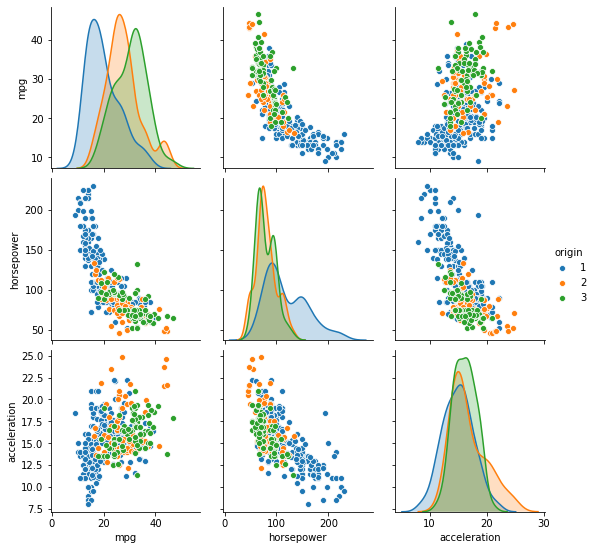

In [633]:
data = cars[["mpg", "horsepower","acceleration", "origin" ]] # let's take four variables and inspect them
sns.pairplot(data,hue="origin"); # show pair by pair plot for all variables, color indicates origin

We can see that `mpg` and `horsepower` seems to be non-linear. 

We could therefore decide (and test) to transform one or both of the variables. 

Let's see how that works.

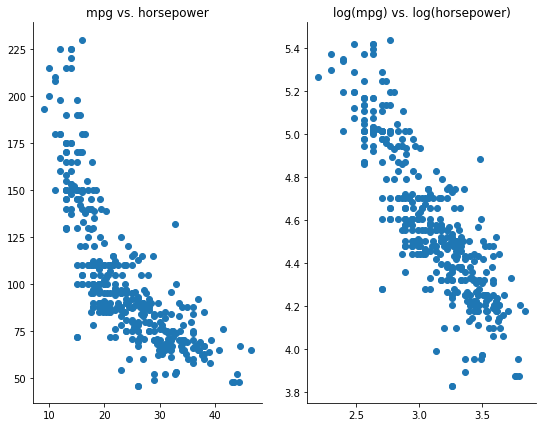

In [638]:
x, y = data["mpg"], data["horsepower"]
fig, axes = plt.subplots(ncols=2, figsize=(9,7))
ax1, ax2 = axes
ax1.scatter(x,y), ax1.set_title("mpg vs. horsepower")
ax2.scatter(np.log(x), np.log(y)), ax2.set_title("log(mpg) vs. log(horsepower)")
sns.despine()

Let's run a regression analysis on both models

In [639]:
y, X = dmatrices("mpg ~ horsepower", cars)
ols1 = sm.OLS(y,X).fit()
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           7.03e-81
Time:                        22:11:49   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

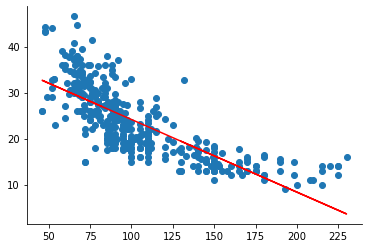

In [640]:
yhat = ols1.fittedvalues
plt.scatter(X[:,1],y)
plt.plot(X[:,1],yhat, color="red")
sns.despine()

In [663]:
y, X = dmatrices("np.log(mpg) ~ np.log(horsepower)", cars)
ols2 = sm.OLS(y,X).fit()
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1016.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          1.13e-110
Time:                        22:46:35   Log-Likelihood:                 118.52
No. Observations:                 392   AIC:                            -233.0
Df Residuals:                     390   BIC:                            -225.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.9606      0.121     57.296      0.000       6.722       7.199
np.log(horsepower)    -0.8418      0.026    -31.881      0.000      -0.894      -0.790
==============================================================================
Omnibus:                        6.244   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.144
Skew:                          -0.122   Prob(JB):                       0.0170
Kurtosis:                       3.663   Cond. No.                         64.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

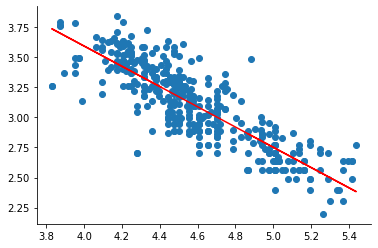

In [632]:
yhat = ols2.fittedvalues
plt.scatter(X[:,1],y)
plt.plot(X[:,1],yhat, color="red")
sns.despine()

Just looking at the two graphs we can see that the second model (log-log) seems to be better and capturing / explaining the deviation. We can also confirm this when looking at the $R^2$ value which is $72$% vs. $61$%.

## Interaction effects

A special case of non-linearity occurs when we combine two or more variables multiplicatively. This may be necessary or feasible if one effect depends (or is conditional) on another effect. 

Let's return to our `advertisment` data set where we analyzed the causal relationship between `sales` and advertisment spent on `TV`,  `newspaper` and `radio`.

In [665]:
df = Datasets.advertising(dtype="pandas", col="all")
y, X = dmatrices("sales ~ TV  + radio", df)
sales_model = sm.OLS(y,X).fit()
sales_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           4.83e-98
Time:                        22:46:42   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model assumes that the effect of increasing advertisment spent in one medium (e.g. TV) is independent of the amount spent on the other media. The effect on `sales` of spending one additional unit on `TV` is always $\beta_{tv}$ irrespective of the amount spent on e.g. `radio`. 

This assumption may be wrong and therefore the specified model may be incorrect.  For example, the amount spent on `radio` may actually  increase the effectiveness of `TV` advertisment. 

This synergy (or dysynergy) effect is referred to as **interaction effect** in statistics.  

One way of incorporating this interaction effect into a regression model is to combine variables multiplicatively such that 

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_1X_2 + \epsilon$$

This can be rearranged such that:

\begin{equation}
\begin{split}
Y &= \beta_0 + (\beta_1+\beta_3X_2)X_1 + \beta_2X_2 + \epsilon \\ 
& =  \beta_0 + \tilde{\beta}X_1 + \beta_2X_2 + \epsilon
\end{split}
\end{equation}

In this case $\tilde{\beta}$ changes with $X_2$. Therefore, the effect of $X_1$ on $Y$ is no longer constant given that adjusting $X_2$ changes $X_1$ and $Y$.

Let's look at our dataset and include the interaction effect of `TV`x`radio`. 

In [656]:
y, X = dmatrices("sales ~ TV + radio + TV:radio", df, return_type="dataframe") # Note: TV:radio indicates that we want the interaction term
X.head()

,Intercept,TV,radio,TV:radio
0,1.0,230.1,37.8,8697.78
1,1.0,44.5,39.3,1748.85
2,1.0,17.2,45.9,789.48
3,1.0,151.5,41.3,6256.95
4,1.0,180.8,10.8,1952.64


In [666]:
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           4.83e-98
Time:                        22:46:46   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the inclusion of the effedt increased $R^2_\text{adj}$ significantly. Also the coefficient `TV:radio` ($\beta_3$) is highly significant. 

Interpretation of $\beta_3$: increase in effectiveness of TV advertisment on radio advertisment (or the other way around).

## Dealing with qualitative data

Up until now we have only worked with quantitative data, i.e. all variables in our models where numerical. However, this is not always the case. Explanatory variables can, of course, be qualitative. 

For example, in our cars dataset we have a variable `origin`. The variable stores the information from which region the car is (US = 1, Europe = 2, Asia = 3).

In [672]:
cars["origin"].unique()

array([1, 3, 2])

While the data is already encoded to be numerical the information it stores is still qualitative. For example, we cannot compare the data similar to numerial data. There is no numerical order and the distances between the values do not mean anything, i.e. 3 is not bigger than 1 in this case or a statement such as Asia is two more than US does not make sense. 

**How do we deal with this kind of data in our regression model?**

If we deal with two categories (male/female) we can simply create a *dummy variable* (0/1) of the form:

\begin{equation}
  x_i =\begin{cases}
    1, & \text{if $i$th person is female}\\
    0, & \text{if $i$th person is male}
  \end{cases}
\end{equation}

This results in the model:

\begin{equation}
  y_i = \beta_0 + \beta_1x_i + \epsilon =\begin{cases}
    \beta_0 + \beta_1 + \epsilon, & \text{if $i$th person is female}\\
    \beta_0 + \epsilon & \text{if $i$th person is male}
  \end{cases}
\end{equation}


If we deal with more than two categories we need to create additional *dummy variables*. For example in our case we need two variables of the form:

\begin{equation}
  x_{i1} =\begin{cases}
    1, & \text{if $i$th car is from US}\\
    0, & \text{if $i$th car is not from US}
  \end{cases}
\end{equation}

and\begin{equation}
  x_{i2} =\begin{cases}
    1, & \text{if $i$th car is from Asia}\\
    0, & \text{if $i$th car is not from Asia}
  \end{cases}
\end{equation}

If we then use both variables in our model we can describe it as:

\begin{equation}
  y_i = \beta_0 + \beta_1x_{i2} + \beta_2x_{i2} + \epsilon =\begin{cases}
    \beta_0 + \beta_1 + \epsilon, & \text{if $i$th car is from US }\\
    \beta_0 + \beta_2 + \epsilon & \text{if $i$th car is from Asia}\\
        \beta_0  + \epsilon & \text{if $i$th car is from Europe}
  \end{cases}
\end{equation}

Let's look at an example using our car dataset. 

If we treat the variable `origin` just as a regular numerial value, the regression model will not yield sensical results. 

In [677]:
y, X = dmatrices("mpg ~ origin", cars, return_type="dataframe") # origin NOT encoded categorically using dummy variables
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     183.1
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           1.81e-34
Time:                        23:10:02   Log-Likelihood:                -1285.8
No. Observations:                 392   AIC:                             2576.
Df Residuals:                     390   BIC:                             2583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.8120      0.716     20.676      0.000      13.404      16.220
origin         5.4765      0.405     13.531      0.000       4.681       6.272
==============================================================================
Omnibus:                       26.546   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.323
Skew:                           0.678   Prob(JB):                     2.60e-07
Kurtosis:                       3.138   Cond. No.                         4.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It does not make sense to say that asian cars (encoded as 3) have an impact of $3\times5.4765$ on mpg, whereas as US cars only have an impact of $1\times5.4765$

However, when encoding the variable as *dummy variable* the model itself is correctly specified and the interpretation is intuitive. 

In [686]:
y, X = dmatrices("mpg ~ C(origin)", cars, return_type="dataframe") # origin encoded categorically using C(origin) 
X.head()

,Intercept,C(origin)[T.2],C(origin)[T.3]
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [678]:
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     96.60
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           8.67e-35
Time:                        23:12:38   Log-Likelihood:                -1282.2
No. Observations:                 392   AIC:                             2570.
Df Residuals:                     389   BIC:                             2582.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.0335      0.409     49.025      0.000      19.230      20.837
C(origin)[T.2]     7.5695      0.877      8.634      0.000       5.846       9.293
C(origin)[T.3]    10.4172      0.828     12.588      0.000       8.790      12.044
==============================================================================
Omnibus:                       26.330   Durbin-Watson:                   0.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.217
Skew:                           0.679   Prob(JB):                     2.74e-07
Kurtosis:                       3.066   Cond. No.                         3.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**How do we interpret the model results?** 

The model yields two coefficients (besides the intercept):

- coefficient for `origin=2` is $7.57$
- coefficient for `origin=3` is $10.42$

They can be interpreted as follows. 

- the fact that the car is European (ceteris paribus) increases mpg by $7.57$
- the fact that the car is Asian (ceteris paribus) increases mpg by $10.42$
- the US case is not modelled explicitly but we can deduct that the mpg for US cars is $7.57$ lower compared to European cars and $10.42$ lower compared to Asian cars (on average)



**Creating dummy variables**

We have created dummy variables using `C(origin)` (C stands for categorical data). We can also do this (i) manually or (ii) using pandas.

In [685]:
# manually:
y, X = dmatrices("mpg ~ origin", cars, return_type="dataframe")
origin = X["origin"]
X["European"] = np.where(origin == 2, 1, 0)
X["Asia"] = np.where(origin == 3, 1, 0)
X = X.drop(labels="origin", axis=1)
X

,Intercept,European,Asia
0,1.0,0,0
1,1.0,0,0
2,1.0,0,0
3,1.0,0,0
4,1.0,0,0
...,...,...,...
387,1.0,0,0
388,1.0,1,0
389,1.0,0,0
390,1.0,0,0


In [689]:
# using pandas
pd.get_dummies(origin, drop_first=True)

,2.0,3.0
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
387,0,0
388,1,0
389,0,0
390,0,0
